# 线性回归

线性回归模型是解决回归任务的好起点。

你可能对线性回归模型最简单的形式（即对数据拟合一条直线）已经很熟悉了，不过经过扩展，这些模型可以对更复杂的数据行为进行建模。

首先导入常用的程序库：

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## 1. 简单线性回归

首先来介绍最广为人知的线性回归模型——将数据拟合成一条直线。直线拟合的模型方程为$y = ax + b$，其中$a$是直线斜率，$b$是直线截距。

下面的数据，它们是从斜率为2、截距为-5 的直线中抽取的散点

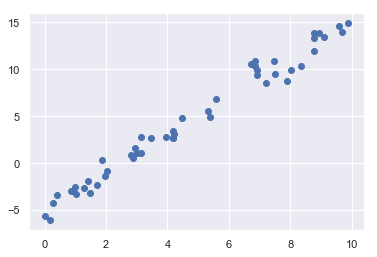

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

用Scikit-Learn 的LinearRegression 评估器来拟合数据，并获得最佳拟合直线

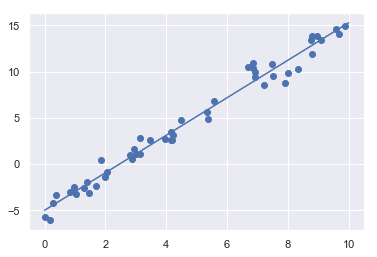

In [5]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

数据的斜率和截距都在模型的拟合参数中，Scikit-Learn 通常会在参数后面加一条下划线，即coef_ 和intercept_：

In [4]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.027208810360695
Model intercept: -4.998577085553202


可以看到，拟合结果与真实值非常接近。

LinearRegression 评估器能做的可远不止这些——除了简单的直线拟合，它还可以处理多维度的线性回归模型：

$$
y = a_0 + a_1 x_1 + a_2 x_2 + \cdots
$$

里面有多个x 变量。从几何学的角度看，这个模型是拟合三维空间中的一个平面，或者是为更高维度的数据点拟合一个超平面。

In [6]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5000000000000144
[ 1.5 -2.   1. ]


其中y 变量是由3个随机的x变量线性组合而成，线性回归模型还原了方程的系数。

通过这种方式，就可以用一个LinearRegression 评估器拟合数据的回归直线、平面和超平面了。

**局限性： 变量限制在线性关系上**

## 2.　基函数回归

可以通过基函数对原始数据进行变换，从而将变量间的线性回归模型转换为非线性回归模型。

这个方法的多维模型是：

$$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots
$$

其中一维的输入变量$x$转换成了三维变量$x_1, x_2, x_3,$。让$x_n = f_n(x)$，这里的$f_n()$是转换数据的函数。

假如$f_n(x) = x^n$，那么模型就会变成多项式回归：

$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$

需要注意的是，这个模型仍然是一个线性模型，也就是说系数 $a_n$彼此不会相乘或相除。

**1. 多项式基函数**

多项式投影非常有用，因此Scikit-Learn 内置了PolynomialFeatures 转换器实现这个功能：

In [7]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

转换器通过指数函数，将一维数组转换成了三维数组。这个新的高维数组之后可以放在多项式回归模型中。

我们创建一个7 次多项式回归模型：

In [8]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

数据经过转换之后，我们就可以用线性模型来拟合x 和y 之间更复杂的关系了。



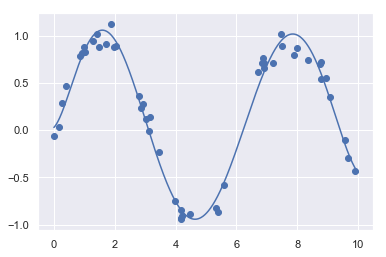

In [9]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

通过运用7 次多项式基函数，这个线性模型可以对非线性数据拟合出极好的效果！

**2. 高斯基函数**

例如，有一种常用的拟合模型方法使用的并不是一组多项式
基函数，而是一组高斯基函数。

![](http://aliyuntianchipublic.cn-hangzhou.oss-pub.aliyun-inc.com/public/files/image/null/1540964900276_MBSo0VPP2E.jpg)

图中的阴影部分代表不同规模基函数，把它们放在一起时就会产生平滑的曲线。



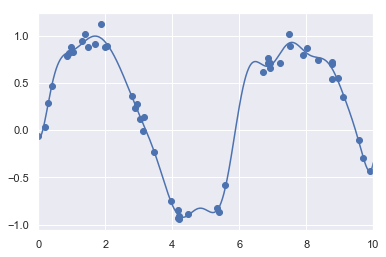

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

## 3.　正则化

虽然在线性回归模型中引入基函数会让模型变得更加灵活，但是也很容易造成过拟合。例如，如果选择了太多高斯基函数，那么最终的拟合结果看起来可能并不好。


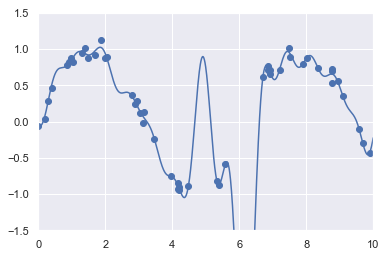

In [11]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

如果将数据投影到30 维的基函数上，模型就会变得过于灵活，从而能够适应数据中不同位置的异常值。如果将高斯基函数的系数画出来，就可以看到过拟合的原因。



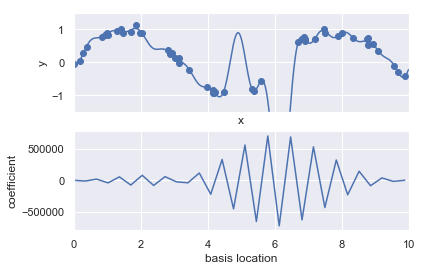

In [12]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

下面那幅图显示了每个位置上基函数的振幅。当基函数重叠的时候，通常就表明出现了过拟合：相邻基函数的系数相互抵消。这显然是有问题的，如果对较大的模型参数进行惩罚（penalize），从而抑制模型剧烈波动，应该就可以解决这个问题了。这个惩罚机制被称为正则化（regularization），有几种不同的表现形式。

**1. 岭回归（L2范数正则化）**

正则化最常见的形式可能就是**岭回归（ridge regression，或者L2 范数正则化）**，有时也被称为吉洪诺夫正则化（Tikhonov regularization）。其处理方法是对模型系数平方和（L2 范数）进行惩罚，模型拟合的惩罚项为：

$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$

α 是一个自由参数，用来控制惩罚的力度。这种带惩罚项的模型内置在Scikit-Learn的Ridge 评估器中




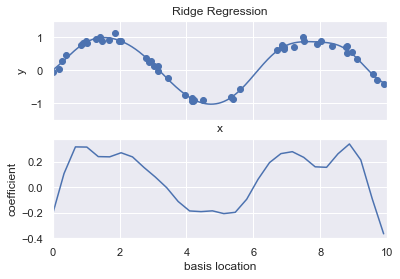

In [13]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

参数α 是控制最终模型复杂度的关键。如果α → 0，那么模型就恢复到标准线性回归结果；如果α → ∞，那么所有模型响应都会被压制。

**2. Lasso正则化（L1范数）**

另一种常用的正则化被称为Lasso，其处理方法是对模型系数绝对值的和（L1 范数）进行惩罚:

$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$

虽然它在形式上非常接近岭回归，但是其结果与岭回归差别很大。例如，由于其几何特性，Lasso 正则化倾向于构建稀疏模型；也就是说，它更喜欢将模型系数设置为0。

模型系数的L1- 范数正则化实现的

F:\anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


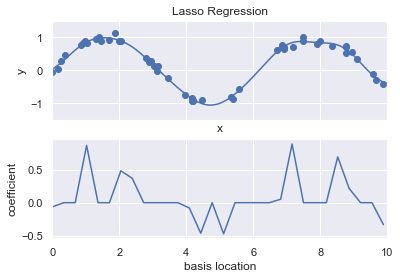

In [14]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

## 4.　案例：预测自行车流量

首先加载两个数据集，用日期作索引:

In [15]:
import pandas as pd
counts = pd.read_csv('./dataset/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('./dataset/BicycleWeather.csv', index_col='DATE', parse_dates=True)

计算每一天的自行车流量，将结果放到一个新的DataFrame中

In [16]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

我们发现同一周内每一天的模式都是不一样的。因此，我们在数据中加上7 列0~1 值表示星期几:

In [17]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

我们觉得骑车人数在节假日也有所变化。因此，再增加一列表示当天是否为节假日:

In [18]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

我们还认为白昼时间也会影响骑车人数。因此，用标准的天文计算来添加这列信息:

(8, 17)

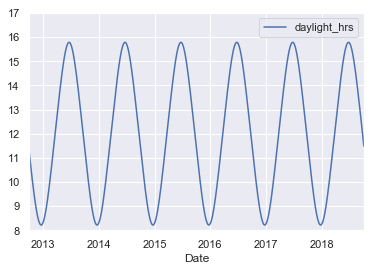

In [19]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

我们还可以增加每一天的平均气温和总降雨量。除了降雨量的数值之外，再增加一个标记表示是否下雨（是否降雨量为0）

In [20]:
# 温度是按照1/10摄氏度统计的，首先转换为摄氏度
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

最后，增加一个从1 开始递增的计数器，表示一年已经过去了多少天。这个特征可以让我们看到每一年自行车流量的增长或减少：

In [21]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

数据已经准备就绪，来看看前几行：

In [22]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


有了这些数据之后，就可以选择需要使用的列，然后对数据建立线性回归模型。我们不在模型中使用截距，而是设置fit_intercept = False，因为每一天的总流量（Total 字段）基本上可以作为当天的截距。

In [23]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

最后，对比自行车真实流量（Total 字段）与预测流量（predicted 字段）

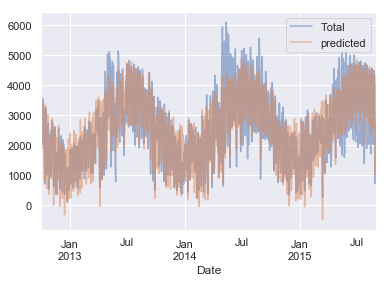

In [24]:
daily[['Total', 'predicted']].plot(alpha=0.5);

显然，我们丢失了一些关键特征，尤其是夏天的预测数据。要么是由于特征没有收集全（即可能还有其他因素会影响人们是否骑车），要么是有一些非线性关系我们没有考虑到（例如，可能人们在温度过高或过低时都不愿意骑车）

评估各个特征对每日自行车流量的影响：

In [25]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              504.882756
Tue              610.233936
Wed              592.673642
Thu              482.358115
Fri              177.980345
Sat            -1103.301710
Sun            -1133.567246
holiday        -1187.401381
daylight_hrs     128.851511
PRCP            -664.834882
dry day          547.698592
Temp (C)          65.162791
annual            26.942713
dtype: float64

如果不对这些数据的不确定性进行评估，那么它们很难具有解释力。可以用自举重采样方法快速计算数据的不确定性：

In [26]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

有了估计误差之后，再来看这些结果：

In [27]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            505.0   86.0
Tue            610.0   83.0
Wed            593.0   83.0
Thu            482.0   85.0
Fri            178.0   81.0
Sat          -1103.0   80.0
Sun          -1134.0   83.0
holiday      -1187.0  163.0
daylight_hrs   129.0    9.0
PRCP          -665.0   62.0
dry day        548.0   33.0
Temp (C)        65.0    4.0
annual          27.0   18.0


首先，星期特征是比较稳定的，工作日骑车的人数显然比周末和节假日要多。其次，白昼时间每增加1 小时，就平均增加129 ± 9 个骑车的人；而温度每上升1 度，则增加65 ± 4 个骑车的人；如果那天没下雨，那么骑车人数增加546 ± 33 人；降雨量每增加1 英寸，骑车人数减少665 ± 62 人。当所有影响因素都生效之后，一年中每多一天骑车人数增加（日环比增幅）28 ± 18 人。


我们的模型的确丢失了一些重要信息。例如，变量的非线性影响因素（例如降雨和寒冷天气的影响）和非线性趋势（例如人们在温度过高或过低时可能都不愿意骑车）在模型中都没有体现。另外，我们丢掉了一些细颗粒度的数据（例如下雨天的早晨和下雨天的傍晚之间的差异），还忽略了相邻日期彼此间的相关性（例如下雨的星期二对星期三骑车人数的影响，或者滂沱大雨之后意外的雨过天晴对骑车人数的影响），这些都可能对骑车人数产生影响。现在你手上已经有了工具，如果愿意，可以进一步进行分析。